In [1]:
import cv2
import glob
import numpy as np
from math import *
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimage

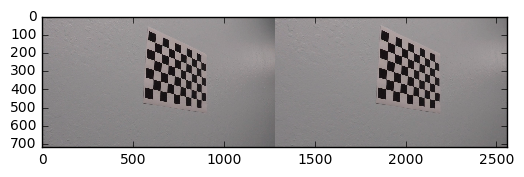

In [2]:
def calibrate_camera(images, nx, ny):
    objpoints = []  # 3D points
    imgpoints = []  # 2D points

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    fname = cal_images[0]
    for fname in cal_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    im = np.hstack((img, dst))
    plt.imshow(im)
    plt.show()
    
    return mtx, dist

cal_images = glob.glob('camera_cal/calibration*.jpg')
nx, ny = 9, 6
cam_mtx, cam_dist = calibrate_camera(cal_images, nx, ny)

In [351]:
def sobel(gray, orient='x', sobel_kernel=3):
    return cv2.Sobel(gray, cv2.CV_64F, orient == 'x', orient == 'y', ksize=sobel_kernel)

def abs_sobel_thresh(sobel, thresh=(0, 255)):
    # Calculate directional gradient
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    retval, output = cv2.threshold(scaled_sobel, thresh[0], thresh[1], cv2.THRESH_BINARY)
    return output

def mag_thresh(sobelx, sobely, thresh=(0, 255)):
    # Calculate gradient magnitude
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)
    mag_sobel = (255*mag_sobel/np.max(mag_sobel)).astype(np.uint8)

    retval, output = cv2.threshold(mag_sobel, thresh[0], thresh[1], cv2.THRESH_BINARY)
    return output

def dir_threshold(sobelx, sobely, thresh=(0, np.pi/2)):
    # Here I'm suppressing annoying error messages
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = (np.absolute(np.arctan(sobely/sobelx)))
        dir_binary =  np.zeros_like(absgraddir, dtype=np.uint8)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1

    return dir_binary

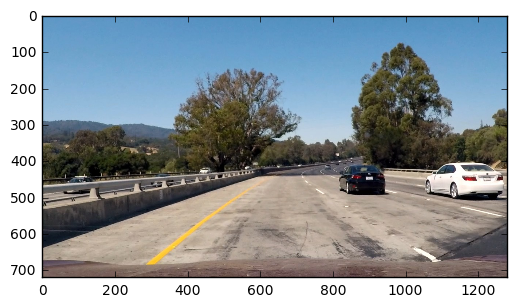

In [352]:
image = mpimage.imread('test_images/test1.jpg')
plt.imshow(image)
plt.show()

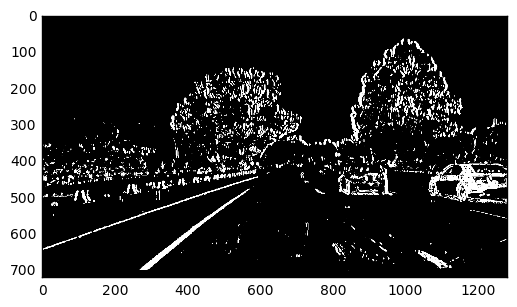

In [353]:
def find_edges(image, ksize = 15):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    sobelx = sobel(gray, orient='x', sobel_kernel=ksize)
    gradx = abs_sobel_thresh(sobelx, thresh=(30, 70))
    
    # sobely = sobel(gray, orient='y', sobel_kernel=ksize)
    # grady = abs_sobel_thresh(sobely, thresh=(90, 255))
    # mag_binary = mag_thresh(sobelx, sobely, thresh=(40, 100))
    # dir_binary = dir_threshold(sobelx, sobely, thresh=(0.7, 1.3))

    _, s_binary = cv2.threshold(s.astype('uint8'), 170, 255, cv2.THRESH_BINARY)

    color_binary = np.dstack(( np.zeros_like(gradx), gradx, s_binary))
    combined_binary = np.clip(cv2.bitwise_or(s_binary, gradx), 0, 1).astype('uint8')
    return combined_binary

undist = cv2.undistort(image, cam_mtx, cam_dist, None, cam_mtx)

edges = find_edges(undist)
plt.imshow(edges, cmap='gray')
plt.show()

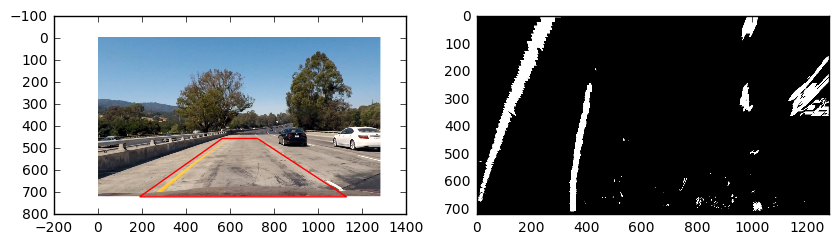

In [363]:
# Perspective transform
# 508, 567   # row x col 
# 508, 777

# 645, 383
# 645, 1019

def unwarp_image(img, mtx):
    return cv2.warpPerspective(img, mtx, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)


img_size = image.shape
# src = np.array([[566., 455.],
#                 [789., 455.],
#                 [1020., 645.],
#                 [375., 645.]], np.float32)
src = np.array([[565. /1280.*img_size[1], 455./720.*img_size[0]],
                [725. /1280.*img_size[1], 455./720.*img_size[0]],
                [1130./1280.*img_size[1], 720./720.*img_size[0]],
                [190. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)

dst = np.array([[300. /1280.*img_size[1], 0.  /720.*img_size[0]],
                [1000./1280.*img_size[1], 0.  /720.*img_size[0]],
                [1000./1280.*img_size[1], 720./720.*img_size[0]],
                [300. /1280.*img_size[1], 720./720.*img_size[0]]], np.float32)

warp_m = cv2.getPerspectiveTransform(src, dst)
warp_minv= cv2.getPerspectiveTransform(dst, src)

lanes = unwarp_image(edges, warp_m)

# plt.rcParams['figure.figsize'] = figsize=(10,12)

plt.figure(figsize=(10,12))
plt.subplot(1, 2, 1)
plt.imshow(undist)
plt.fill(src[:,0], src[:,1], edgecolor='r', fill=False)

plt.subplot(1, 2, 2)
plt.imshow(lanes, cmap='gray')

plt.show()

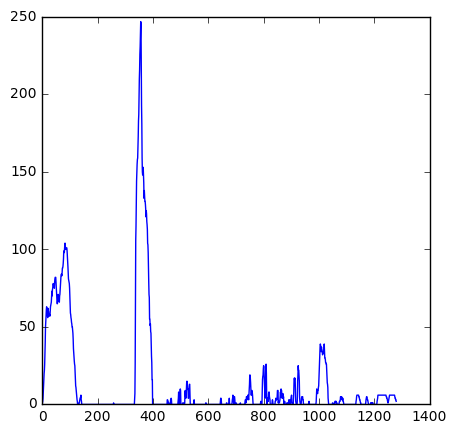

In [364]:
histogram = np.sum(lanes[int(lanes.shape[0]*0.5):,:], axis=0)
plt.figure(figsize=(5,5))
plt.plot(histogram)

In [365]:
from scipy.signal import find_peaks_cwt

def find_base_points(lanes, min_peak = 30):
    """Uses histogram to find possible base points for lane lines"""
    hist = np.sum(lanes[int(lanes.shape[0]*0.5):,:], axis=0)
    idx = find_peaks_cwt(hist, np.arange(10,100), max_distances=np.arange(10,100))
    idx = np.array([i for i in idx if hist[i] >= min_peak])
    middle = len(hist)//2.
    left_idx = idx < middle
    right_idx = idx >= middle
    left_pt = max(idx[left_idx])
    right_pt = min(idx[right_idx])
    return left_pt, right_pt

base_pts = find_base_points(lanes)
print(base_pts)

(352, 1014)


In [366]:
print(np.sum(lanes, axis=0).shape)

(1280,)


In [367]:
# Sliding window to detect left and right 
def find_lane_curve(lanes, base_pts, num_bands = 20, window_size = 0.05):
    height = lanes.shape[0]
    band_height = int(1./num_bands * height)   # Divide image into horizontal bands
    band_width = int(window_size*lanes.shape[1])
    
    y_pts = np.arange(0, num_bands)*band_height + band_height//2.
    left_pts = []
    right_pts = []
    
    l_x, l_y, r_x, r_y = [], [], [], []
    
    base_left, base_right = base_pts
    idx_left, idx_right = base_pts
    for i in reversed(range(num_bands)):
        w_left = lanes[i*band_height:(i+1)*band_height,base_left-band_width//2:base_left+band_width//2]
        w_right = lanes[i*band_height:(i+1)*band_height,base_right-band_width//2:base_right+band_width//2]
        
        left_y_pt, left_x_pt = np.nonzero(w_left)
        right_y_pt, right_x_pt = np.nonzero(w_right)
        
        l_x.extend(left_x_pt + base_left-band_width//2)
        l_y.extend(left_y_pt + i*band_height)
        r_x.extend(right_x_pt+ base_right-band_width//2)
        r_y.extend(right_y_pt+ i*band_height)

        # Find 'x' with maximum nonzero elements as baseline for next window
        s_left = np.sum(w_left, axis=0)
        s_right = np.sum(w_right, axis=0)
        if np.any(s_left > 0):
            base_left = np.argmax(s_left) + base_left-band_width//2
        if np.any(s_right > 0):
            base_right = np.argmax(s_right) + base_right-band_width//2
    
    p_left = np.polyfit(l_y, l_x, 2)
    p_right = np.polyfit(r_y, r_x, 2)

    return p_left, p_right
p_left, p_right = find_lane_curve(lanes, base_pts)

In [368]:
yvals = np.linspace(0, lanes.shape[0],101)
left_fitx = p_left[0]*yvals**2 + p_left[1]*yvals + p_left[2]
right_fitx = p_right[0]*yvals**2 + p_right[1]*yvals + p_right[2]

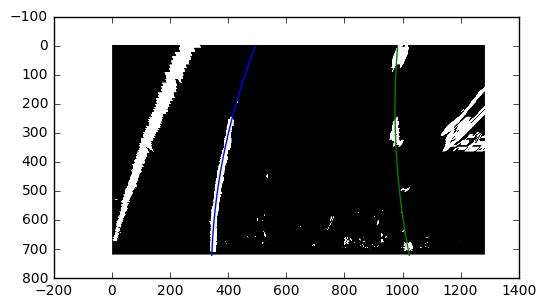

In [369]:
plt.imshow(lanes, cmap='gray')
plt.plot(left_fitx, yvals)
plt.plot(right_fitx, yvals)
plt.show()

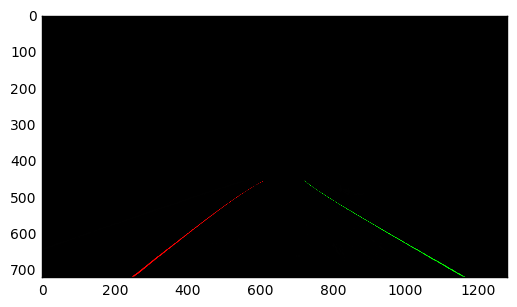

In [379]:
left_lane = np.dstack((left_fitx, yvals)).astype(np.int32)
right_lane = np.dstack((right_fitx, yvals)).astype(np.int32)

out_warp = cv2.cvtColor(lanes, cv2.COLOR_GRAY2BGR)
out_warp = cv2.polylines(out_warp, left_lane, color=(255,0,0), thickness=3, isClosed=False)
out_warp = cv2.polylines(out_warp, right_lane, color=(0,255,0), thickness=3, isClosed=False)
out = unwarp_image(out_warp, warp_minv)
plt.imshow(image)
plt.show()